In [6]:
from ephys import core, events
import numpy as np
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
from itertools import combinations
%matplotlib inline

In [7]:
# Set up birds and block_paths
birds = ['B1083', 'B1056', 'B1235', 'B1075']
bps = {'B1083': '/home/brad/krista/B1083/P03S03/', 'B1075': '/home/brad/krista/B1075/P01S03/',
       'B1235': '/home/brad/krista/B1235/P02S01/', 'B1056': '/home/brad/krista/B1056/klusta/phy020516/Pen01_Lft_AP100_ML1300__Site03_Z2500__B1056_cat_P01_S03_1/',
       'B1056': '/home/brad/krista/B1056/klusta/phy020516/Pen01_Lft_AP100_ML1300__Site03_Z2500__B1056_cat_P01_S03_1/'}

bird = 'B1235'
block_path = bps[bird]

# load spikes, stimuli, clusters
spikes = core.load_spikes(block_path)
clusters = core.load_clusters(block_path)
trials = events.load_trials(block_path)

In [8]:
def get_average_firing_rate(spikes, cluster_id, t_start, t_end, fs):
    '''
    Compute the average firing rate of the cluster <cluster_id> during the time interval [t_start, t_end]
    Average firing rate is (# of spikes in interval) / (duration of interval)
    '''
    cluster_spikes_in_interval = spikes[(spikes['cluster'] == cluster_id) &
                            (spikes['time_samples'] < t_end) & 
                            (spikes['time_samples'] > t_start)
    ]
    n_spikes = cluster_spikes_in_interval.size
    dt = (t_end - t_start) / fs
    return n_spikes / dt

def get_stimulus_average_firing_rate(spikes, trials, cluster_id, stimulus_id, fs):
    '''
    Return the average firing rate of a neuron over all trials from a given stimulus
    '''
    stim_trials = trials[trials['stimulus'] == stimulus_id]
    stim_starts = np.array(stim_trials['time_samples'])
    stim_ends = np.array(stim_trials['stimulus_end'])
    
    avg_fr = 0
    for (s_start, s_end) in zip(stim_starts, stim_ends):
        avg_fr += get_average_firing_rate(spikes , cluster_id, s_start, s_end, fs)
    return avg_fr / stim_trials.size

def get_stimulus_avg_sd_firing_rate(spikes, trials, cluster_id, stimulus_id, fs, interval=[0,1]):
    '''
    Return the mean and standard deviation firing rate of a neuron over all trials from a given stimulus
    '''
    stim_trials = trials[trials['stimulus'] == stimulus_id]
    stim_starts = np.array(stim_trials['time_samples'])
    stim_ends = np.array(stim_trials['stimulus_end'])
    
    fr_list=[]
    for (s_start, s_end) in zip(stim_starts, stim_ends):
        int_start = int(s_start + (s_end - s_start)*interval[0])
        int_end = int(s_start + (s_end - s_start)*interval[1])
        fr_list.append(get_average_firing_rate(spikes , cluster_id, int_start, int_end, fs))
        
    return (np.mean(fr_list), np.std(fr_list))

    
def get_pair_stimulus_average_responses(spikes, trials, cluster_a, cluster_b, fs):
    '''
    Get the average responses from all stimuli for a pair of cells
    '''
    
    stimuli = sorted(trials['stimulus'].unique())
    ret = []
    for stim in stimuli:
        cluster_a_avg_response = get_stimulus_average_firing_rate(spikes, trials, cluster_a, stim, fs)
        cluster_b_avg_response = get_stimulus_average_firing_rate(spikes, trials, cluster_b, stim, fs)
        ret.append([cluster_a_avg_response, cluster_b_avg_response])
    return np.array(ret)


### Noise correlation funcs
def get_zscore_responses(spikes, trials, cluster_id, stimulus_id, fs, interval=[0, 1]):
    ''' Return an array of the z-scored responses from each trial for a given stim and cell'''
    
    # get mean and standard deviation response
    degenerate = False
    mu, sig = get_stimulus_avg_sd_firing_rate(spikes, trials, cluster_id, stimulus_id, fs, interval=interval)
    if (sig < 1e-12):
        print("Uh Oh... standard deviation very small")
        print("Cluster: {} Stimulus: {} mu: {} sigma: {}".format(cluster_id, stimulus_id, mu, sig))
        degenerate = True
    
    # for each trial compute z-score
    stim_trials = trials[trials['stimulus'] == stimulus_id]
    stim_starts = np.array(stim_trials['time_samples'])
    stim_ends = np.array(stim_trials['stimulus_end'])
    
    stim_clu_zscores = []
    for (s_start, s_end) in zip(stim_starts, stim_ends):
        int_start = int(s_start + (s_end - s_start)*interval[0])
        int_end = int(s_start + (s_end - s_start)*interval[1])
        if degenerate:
            stim_clu_zscores.append(0.0)
        else:
            trial_fr = get_average_firing_rate(spikes, cluster_id, int_start, int_end, fs)
            zscore = (trial_fr - mu)/sig
            stim_clu_zscores.append(zscore)
    return np.array(stim_clu_zscores)
    
def get_stim_zscores(spikes, trials, clusters, stimulus_id, fs, interval=[0, 1]):
    ''' Get an ncell x ntrial array of zscores for a given stim'''
    
    stimulus_zscores = []
    for cluster in clusters:
        stimulus_zscores.append(get_zscore_responses(spikes, trials, cluster, stimulus_id, fs, interval=interval))
    return np.vstack(stimulus_zscores)

def get_all_stim_zscores(spikes, trials, clusters, fs, interval=[0, 1]):
    ''' Return an ncell x ntrial x nstim array of zscores'''
    
    stimuli = sorted(trials['stimulus'].unique())
    all_stim_zscores = []
    for stim in stimuli:
        all_stim_zscores.append(get_stim_zscores(spikes, trials, clusters, stim, fs, interval=interval))
    return np.dstack(all_stim_zscores)
    
def get_pair_noise_correlation(stim_zscores, cluster_a, cluster_b):
    '''
    given an ncell x ntrial array of z-scores, compute the noise correlation between cells index a and index b
    cluster_a is the *index* of the cell, not its id
    '''

    z_a = stim_zscores[cluster_a, :]
    z_b = stim_zscores[cluster_b, :]
    return pearsonr(z_a, z_b)[0]

def get_pair_stim_avg_noise_correlation(all_stim_zscores, cluster_a, cluster_b):
    '''
    For a pair of cells given by *index* cluster_a, cluster_b, compute the noise correlation averaged over all stimuli
    
    '''
    
    nstim = all_stim_zscores.shape[2]
    corrs = []
    for stimnum in range(nstim):
        corrs.append(get_pair_noise_correlation(all_stim_zscores[:, :, stimnum], cluster_a, cluster_b))
    return np.mean(corrs)

def get_all_stim_avg_noise_correlation(all_stim_zscores, clusters):
    ''' Compute the stimulus averaged noise correlation from all pairs of cells
    all_stim_zscores is an ncell x ntrial x nstim array
    
    '''
    
    all_noise_corrs = []
    for pair in tqdm(combinations(range(len(clusters)),2)):
        all_noise_corrs.append(get_pair_stim_avg_noise_correlation(all_stim_zscores, pair[0], pair[1]))
    return np.array(all_noise_corrs)
    
###################################   
## Signal correlations
def get_signal_correlation(spikes, trials, cluster_a, cluster_b, fs):
    ''' Compute the signal correlation for a pair of cells
    
    spikes - spikes dataframe
    trials - trials dataframe containing all the trials for which you wish to compute signal correlations
                (e.g. all the trials from a particular class of stimuli)
    cluster_a - the *cluster id* of the first cell in the pair
    cluster_b - the *cluster id* of the second cell in the pair
    fs - sampling rate
    '''
    
    stim_responses = get_pair_stimulus_average_responses(spikes, trials, cluster_a, cluster_b, fs)
    stim_correlation = pearsonr(stim_responses[:, 0], stim_responses[:, 1])[0]
    return stim_correlation

def get_all_average_responses(spikes, trials, clusters, fs):
    ''' Return an ncell x nstim matrix of trial-averaged firing rate responses 
        spikes - spikes dataframe
        trials - trials dataframe containing all the trials for which you wish to compute signal correlations
                (e.g. all the trials from a particular class of stimuli)
        clusters - list of *cluster ids* for which you wish to compute average responses
                    the output array will have clusters indexed in this order
    '''
    
    stimuli = sorted(trials['stimulus'].unique())
    responses = np.zeros((len(clusters), len(stimuli)))
    for i in tqdm(range(len(clusters))):
        for j in range(len(stimuli)):
            responses[i, j] = get_stimulus_average_firing_rate(spikes, trials, clusters[i], stimuli[j], fs)
    return responses

from tqdm import tqdm
def get_all_signal_correlations(responses, clusters):
    ''' given an ncell x nstim matrix of trial averaged firing rate responses, 
    compute the signal correlations for every pair.
    
    responses - an ncell x nstim matrix of trial averaged firing rate responses
    clusters - array of *cluster ids* corresponding to the order of the rows in the response matrix
    '''
    all_pairs_signal_correlations = []
    for pair in tqdm(combinations(range(len(clusters)), 2)):
        response_a = responses[pair[0], :]
        response_b = responses[pair[1], :]
        pair_sig_corr = pearsonr(response_a, response_b)[0]
        all_pairs_signal_correlations.append(pair_sig_corr)
    return np.array(all_pairs_signal_correlations)

In [9]:
good_clusters = clusters[clusters['quality'] == 'Good']['cluster'].unique()
fs = 30000

responses = get_all_average_responses(spikes, trials, good_clusters, fs)
signal_corrs = get_all_signal_correlations(responses, good_clusters)

zscores = get_all_stim_zscores(spikes, trials, good_clusters, fs)
noise_corrs = get_all_stim_avg_noise_correlation(zscores, good_clusters)

100%|██████████| 40/40 [00:18<00:00,  2.17it/s]
780it [00:00, 17852.97it/s]
780it [00:00, 1160.66it/s]


(array([ 1.,  1.,  3.,  3.,  1.,  2.,  7.,  3.,  5.,  6., 13., 14., 25.,
        19., 35., 43., 43., 38., 46., 45., 42., 58., 44., 41., 40., 27.,
        24., 39., 16., 22., 26., 18., 12., 10.,  8.]),
 array([-0.62816849, -0.5843919 , -0.5406153 , -0.49683871, -0.45306212,
        -0.40928553, -0.36550894, -0.32173234, -0.27795575, -0.23417916,
        -0.19040257, -0.14662598, -0.10284938, -0.05907279, -0.0152962 ,
         0.02848039,  0.07225698,  0.11603357,  0.15981017,  0.20358676,
         0.24736335,  0.29113994,  0.33491653,  0.37869313,  0.42246972,
         0.46624631,  0.5100229 ,  0.55379949,  0.59757609,  0.64135268,
         0.68512927,  0.72890586,  0.77268245,  0.81645905,  0.86023564,
         0.90401223]),
 <a list of 35 Patch objects>)

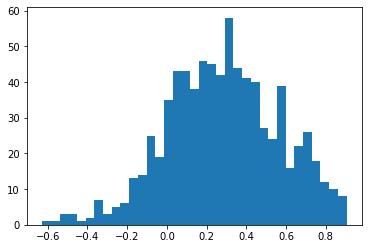

In [10]:
plt.hist(signal_corrs, bins=35)

(array([ 3.,  3.,  4.,  8., 15., 28., 34., 43., 51., 60., 43., 58., 59.,
        44., 55., 46., 43., 32., 28., 18., 20., 19., 18., 12.,  6.,  7.,
         6.,  3.,  3.,  2.,  1.,  3.,  2.,  1.,  2.]),
 array([-0.12175141, -0.10288256, -0.08401371, -0.06514485, -0.046276  ,
        -0.02740715, -0.00853829,  0.01033056,  0.02919941,  0.04806827,
         0.06693712,  0.08580597,  0.10467483,  0.12354368,  0.14241253,
         0.16128138,  0.18015024,  0.19901909,  0.21788794,  0.2367568 ,
         0.25562565,  0.2744945 ,  0.29336336,  0.31223221,  0.33110106,
         0.34996992,  0.36883877,  0.38770762,  0.40657648,  0.42544533,
         0.44431418,  0.46318304,  0.48205189,  0.50092074,  0.51978959,
         0.53865845]),
 <a list of 35 Patch objects>)

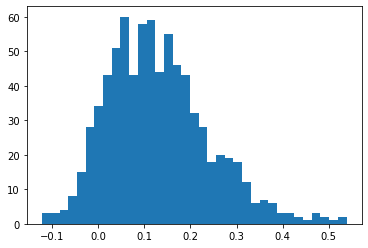

In [11]:
plt.hist(noise_corrs, bins=35)

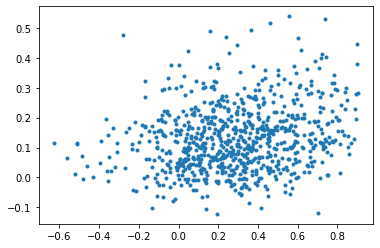

In [12]:
plt.plot(signal_corrs, noise_corrs, '.')

In [13]:
nas = np.logical_or(np.isnan(signal_corrs), np.isnan(noise_corrs))
print(pearsonr(signal_corrs[~nas], noise_corrs[~nas]))

(0.22000638249128668, 5.270114853552006e-10)


In [ ]:
np.isnan(noise_corrs[nas]).any()

In [14]:
np.nanmean(noise_corrs)

0.13047003382751018

In [86]:
stimuli = sorted(trials['stimulus'].unique())
print(stimuli)

['A_scaled_burung', 'B_scaled_burung', 'C_scaled_burung', 'D_scaled_burung', 'E_scaled_burung', 'F_scaled_burung', 'G_scaled_burung', 'H_scaled_burung', 'I_scaled_burung', 'J_scaled_burung', 'K_scaled_burung', 'L_scaled_burung', 'M_scaled_burung', 'N_scaled_burung', 'O_scaled_burung', 'P_scaled_burung']


In [85]:
fam_stim = ['E_scaled_burung', 'F_scaled_burung', 'G_scaled_burung', 'H_scaled_burung']
all_unfam_stim = ['A_scaled_burung', 'B_scaled_burung', 'C_scaled_burung', 'D_scaled_burung','I_scaled_burung', 'J_scaled_burung', 'K_scaled_burung', 'L_scaled_burung', 'M_scaled_burung', 'N_scaled_burung', 'O_scaled_burung', 'P_scaled_burung']
# unfam_stim = ['A_scaled_burung', 'B_scaled_burung', 'C_scaled_burung', 'D_scaled_burung']
# unfam_stim = ['I_scaled_burung', 'J_scaled_burung', 'K_scaled_burung', 'L_scaled_burung',]
# unfam_stim = ['M_scaled_burung', 'N_scaled_burung', 'O_scaled_burung', 'P_scaled_burung']

#unfam_stim = np.random.choice(all_unfam_stim, size=4, replace=False)
unfam_stim = all_unfam_stim

fam_trials = trials[trials['stimulus'].isin(fam_stim)]
unfam_trials = trials[trials['stimulus'].isin(unfam_stim)]

In [73]:
fam_responses = get_all_average_responses(spikes, fam_trials, good_clusters, fs)
unfam_responses = get_all_average_responses(spikes, unfam_trials, good_clusters, fs)
fam_signal_corrs = get_all_signal_correlations(fam_responses, good_clusters)
unfam_signal_corrs = get_all_signal_correlations(unfam_responses, good_clusters)

fam_zscores = get_all_stim_zscores(spikes, fam_trials, good_clusters, fs)
fam_noise_corrs = get_all_stim_avg_noise_correlation(fam_zscores, good_clusters)
unfam_zscores = get_all_stim_zscores(spikes, unfam_trials, good_clusters, fs)
unfam_noise_corrs = get_all_stim_avg_noise_correlation(unfam_zscores, good_clusters)

100%|██████████| 40/40 [00:13<00:00,  2.90it/s]
780it [00:00, 19932.11it/s]
780it [00:00, 21818.38it/s]
780it [00:00, 4196.43it/s]
780it [00:00, 1510.81it/s]


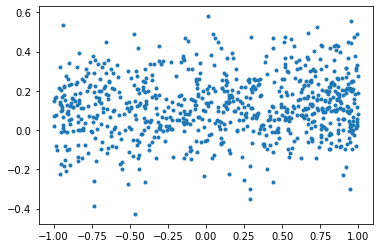

In [74]:
plt.plot(fam_signal_corrs, fam_noise_corrs, '.')

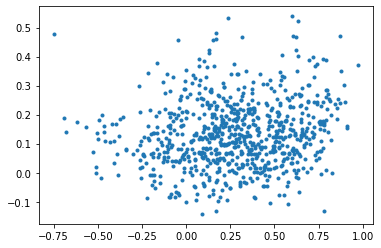

In [75]:
plt.plot(unfam_signal_corrs, unfam_noise_corrs, '.')

In [76]:
nas = np.logical_or(np.isnan(fam_signal_corrs), np.isnan(fam_noise_corrs))
print(pearsonr(fam_signal_corrs[~nas], fam_noise_corrs[~nas]))

(0.1067753569895677, 0.0028280918981679463)


In [77]:
nas = np.logical_or(np.isnan(unfam_signal_corrs), np.isnan(unfam_noise_corrs))
print(pearsonr(unfam_signal_corrs[~nas], unfam_noise_corrs[~nas]))

(0.1412010383998773, 7.58817932889914e-05)


(array([21., 28., 24., 17., 22., 17., 22., 12., 14., 23., 22., 18., 16.,
        12., 17., 21., 21., 18., 16., 27., 19., 17., 24., 18., 17., 20.,
        26., 19., 22., 36., 27., 32., 36., 35., 44.]),
 array([-0.99940962, -0.94230345, -0.88519728, -0.82809111, -0.77098495,
        -0.71387878, -0.65677261, -0.59966644, -0.54256027, -0.4854541 ,
        -0.42834793, -0.37124176, -0.31413559, -0.25702942, -0.19992325,
        -0.14281709, -0.08571092, -0.02860475,  0.02850142,  0.08560759,
         0.14271376,  0.19981993,  0.2569261 ,  0.31403227,  0.37113844,
         0.42824461,  0.48535077,  0.54245694,  0.59956311,  0.65666928,
         0.71377545,  0.77088162,  0.82798779,  0.88509396,  0.94220013,
         0.9993063 ]),
 <a list of 35 Patch objects>)

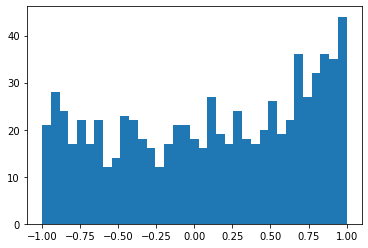

In [78]:
plt.hist(fam_signal_corrs, bins=35)

(array([ 1.,  2.,  1.,  1.,  3.,  8.,  4.,  6.,  2.,  7., 13., 19., 19.,
        28., 29., 24., 32., 47., 54., 46., 46., 52., 48., 35., 33., 39.,
        39., 36., 30., 24., 22., 17.,  7.,  5.,  1.]),
 array([-0.74982557, -0.7005785 , -0.65133143, -0.60208437, -0.5528373 ,
        -0.50359023, -0.45434316, -0.40509609, -0.35584903, -0.30660196,
        -0.25735489, -0.20810782, -0.15886076, -0.10961369, -0.06036662,
        -0.01111955,  0.03812751,  0.08737458,  0.13662165,  0.18586872,
         0.23511578,  0.28436285,  0.33360992,  0.38285699,  0.43210405,
         0.48135112,  0.53059819,  0.57984526,  0.62909233,  0.67833939,
         0.72758646,  0.77683353,  0.8260806 ,  0.87532766,  0.92457473,
         0.9738218 ]),
 <a list of 35 Patch objects>)

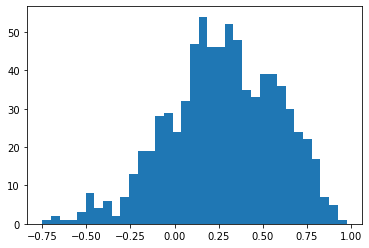

In [79]:
plt.hist(unfam_signal_corrs, bins=35)

(array([ 1.,  1.,  1.,  0.,  2.,  4.,  3.,  6.,  6., 13., 13., 23., 31.,
        20., 45., 54., 55., 49., 75., 51., 53., 52., 50., 46., 19., 29.,
        19., 19.,  7., 12.,  6., 11.,  0.,  2.,  2.]),
 array([-0.42734894, -0.39857571, -0.36980248, -0.34102925, -0.31225601,
        -0.28348278, -0.25470955, -0.22593632, -0.19716309, -0.16838986,
        -0.13961663, -0.11084339, -0.08207016, -0.05329693, -0.0245237 ,
         0.00424953,  0.03302276,  0.06179599,  0.09056922,  0.11934246,
         0.14811569,  0.17688892,  0.20566215,  0.23443538,  0.26320861,
         0.29198184,  0.32075508,  0.34952831,  0.37830154,  0.40707477,
         0.435848  ,  0.46462123,  0.49339446,  0.52216769,  0.55094093,
         0.57971416]),
 <a list of 35 Patch objects>)

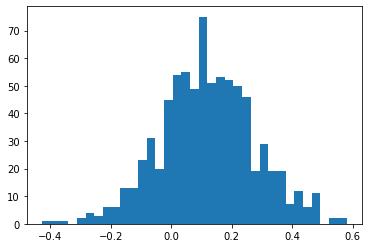

In [80]:
plt.hist(fam_noise_corrs, bins=35)

(array([ 3.,  1., 11., 11., 14., 17., 19., 27., 37., 49., 56., 54., 50.,
        57., 50., 55., 44., 38., 35., 34., 23., 19., 18.,  9., 13.,  5.,
         8.,  7.,  2.,  2.,  3.,  5.,  1.,  0.,  3.]),
 array([-0.14215689, -0.12269051, -0.10322412, -0.08375774, -0.06429136,
        -0.04482498, -0.0253586 , -0.00589221,  0.01357417,  0.03304055,
         0.05250693,  0.07197331,  0.0914397 ,  0.11090608,  0.13037246,
         0.14983884,  0.16930523,  0.18877161,  0.20823799,  0.22770437,
         0.24717075,  0.26663714,  0.28610352,  0.3055699 ,  0.32503628,
         0.34450266,  0.36396905,  0.38343543,  0.40290181,  0.42236819,
         0.44183457,  0.46130096,  0.48076734,  0.50023372,  0.5197001 ,
         0.53916648]),
 <a list of 35 Patch objects>)

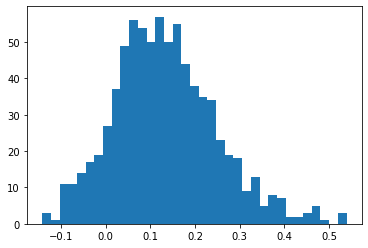

In [81]:
plt.hist(unfam_noise_corrs, bins=35)

In [82]:
np.nanmean(fam_noise_corrs)

0.12011332544627046

In [83]:
np.nanmean(unfam_noise_corrs)

0.1339222699545901

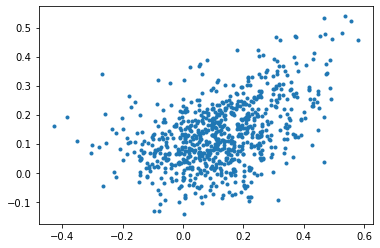

In [84]:
plt.plot(fam_noise_corrs, unfam_noise_corrs, '.')

In [ ]:
test = get_stim_zscores(spikes, trials, good_clusters, 'P_40k', fs)

In [ ]:
test.shape

In [ ]:
stim_subintervals = np.linspace(0, 1, 7)
subint_noisecorrs = []
for (a, b) in tqdm(zip(stim_subintervals[:-1], stim_subintervals[1:])):
    subint_zscores = get_all_stim_zscores(spikes, trials, good_clusters, fs, interval=[a,b])
    subint_noisecorrs.append(get_all_stim_avg_noise_correlation(subint_zscores, good_clusters))

In [ ]:
subint_noisecorrs[0].shape

In [ ]:
nc_v_time = np.array([(i, x) for i, y in enumerate(subint_noisecorrs) for x in y ])
mean_nc_v_time = np.array([(i, np.nanmean(x)) for i, x in enumerate(subint_noisecorrs)])
std_nc_v_time = np.array([(i, np.nanstd(x)) for i, x in enumerate(subint_noisecorrs)])

In [ ]:
plt.plot(nc_v_time[:, 0],  nc_v_time[:, 1], '.')

In [ ]:
plt.plot(mean_nc_v_time[:, 0], mean_nc_v_time[:, 1])